# A Particle Neural Network Toy Model for Jet Classification
This file is a single run of each of the three different neural networks tested (An ordinary neural network, a base model neural network, and an adversarial neural network which uses the base model neural network).

Simulation data is generated for two different classifications, expodential and gaussian masses (each with a different expodential tau distribution).  The inputs to the neural network's data sets are 3-momentum (Px,Py,Pz), the masses, and tau.

The user is free to set the total momentum which is constant for all simulation particles, the size of the training and testing data sets, and the number of epochs to run for all neural networks (more epochs means more accuracy up to a cut off point ~3).

Below are the import statements, as well as some self-built code modulas.

In [1]:
from make_data import make_data
from particle_net import particle_net
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from mpl_toolkits import mplot3d
import neural_structured_learning as nsl
from collections import defaultdict
from adversary import adversary
from base_model import base_model

The user decides the constant momentum used for this simulation for all particles, as well as the size of the training and testing data sets.  The actual size of the test and training data sets is doubled as these numbers are for each distribution. 

In [2]:
momentum = 100
n_train = 1000000
n_test = 1000000
epochs = 5

Here, I create the simulation data of a million particles per distribution for the training and testing data sets.

In [3]:
train,train_vals = make_data(momentum,n_train)
test,test_vals = make_data(momentum,n_test)

Below is a 3D plot of the momentum of each particle.  Notice how all particles have constant total momentum but random direction, resulting in the data points filling out the surface of a sphere.

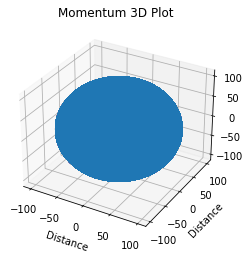

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(train[:,0], train[:,1], train[:,2]);
plt.title('Momentum 3D Plot')
plt.xlabel('Distance')
plt.ylabel('Distance')
fig.savefig('Momentum.png')

Below is a plot of the mass distributions for the training data set.  One expodential, one guassian.

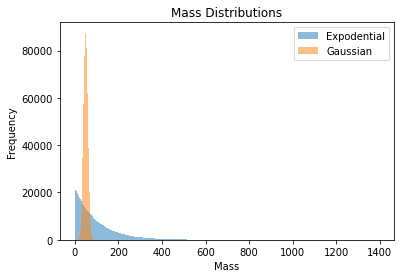

In [5]:
fig = plt.figure()
n,bins,weights = plt.hist(train[train_vals==0,3], bins = 'auto',
                          alpha = 0.5, label = 'Expodential')
plt.hist(train[train_vals==1,3], bins = bins, alpha = 0.5, label = 'Gaussian')
plt.xlabel('Mass')
plt.ylabel('Frequency')
plt.title('Mass Distributions')
plt.legend()
fig.savefig('Mass.png')

Here is a plot of Tau, the measure of N-subjettiness which is different for each mass distribution, and represented by a expodential distribution.

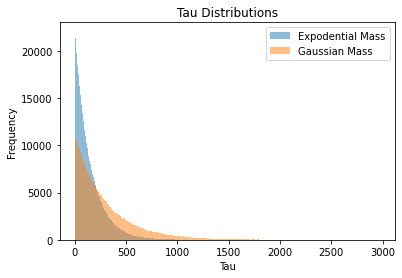

In [6]:
fig = plt.figure()
n,bins,weights = plt.hist(train[train_vals==0,4], bins = 'auto', alpha = 0.5, label = 'Expodential Mass')
plt.hist(train[train_vals==1,4], bins = bins, alpha = 0.5,label = 'Gaussian Mass')
plt.title('Tau Distributions')
plt.xlabel('Tau')
plt.ylabel('Frequency')
plt.legend()
fig.savefig('Tau.png')

Here, I show that the simulation data is shuffled before being fed into the neural networks.  This vector is of the true classifications of each particle, where 0 represents an expodential distribution and 1 a gaussian distribution.

In [7]:
print(test_vals[0:48])

[0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.]


# Ordinary Neural Network

This line of code runs an ordinary neural network model.  The predictions for the test data set are returned.  These predictions are the probability guesses of the neural network for the test data set.  For each particle, the neural network will return a probability for each classification, two numbers in this case, one for the probability that particle is a 0, and another the probability this particle is a 1, representing expodential vs gaussian respectivly.

In [8]:
predictions = particle_net(train,train_vals,test,epochs)

Epoch 1/5
62500/62500 [==============================] - 33s 522us/step - loss: 0.4334 - accuracy: 0.8216
Epoch 2/5
62500/62500 [==============================] - 33s 520us/step - loss: 0.3353 - accuracy: 0.8549
Epoch 3/5
62500/62500 [==============================] - 34s 539us/step - loss: 0.3298 - accuracy: 0.8575
Epoch 4/5
62500/62500 [==============================] - 34s 539us/step - loss: 0.3283 - accuracy: 0.8577
Epoch 5/5
62500/62500 [==============================] - 28s 441us/step - loss: 0.3258 - accuracy: 0.8593

Test accuracy: 0.8593094944953918


Here are the results of this ordinary neural network.  Accuracy is between 74% and 82% and the expodential data particles had a higher chance of being correctly classified than the guassian particles.

In [9]:
print("Ordinary Neural Network:")
false_exps = sum(predictions[np.where(test_vals == 0)])/n_test*100
print("Expodential, Correct: " + str(round(false_exps[0],2)) + " percent.")
print("Expodential, Incorrect:  " + str(round(false_exps[1],2)) + " percent.")
false_gauss = sum(predictions[np.where(test_vals == 1)])/n_test*100
print("Gaussian, Correct: " + str(round(false_gauss[1],2)) + " percent.")
print("Gaussian, Incorrect: " + str(round(false_gauss[0],2)) + " percent.")

Ordinary Neural Network:
Expodential, Correct: 78.52 percent.
Expodential, Incorrect:  21.52 percent.
Gaussian, Correct: 81.19 percent.
Gaussian, Incorrect: 18.83 percent.


# Base Model

This section runs the base model neural network used for the adversarial neural network alone, resulting in its own predictions. The predictions for the test data set are returned.  These predictions are the probability guesses of the neural network for the test data set.  For each particle, the neural network will return a probability for each classification, two numbers in this case, one for the probability that particle is a 0, and another the probability this particle is a 1, representing expodential vs gaussian respectivly.

In [10]:
predicts = base_model(train, train_vals, test, epochs)

Epoch 1/5
62500/62500 [==============================] - 59s 928us/step - loss: 0.3351 - acc: 0.8519
Epoch 2/5
62500/62500 [==============================] - 61s 968us/step - loss: 0.3207 - acc: 0.8597
Epoch 3/5
62500/62500 [==============================] - 58s 929us/step - loss: 0.3197 - acc: 0.8600
Epoch 4/5
62500/62500 [==============================] - 56s 888us/step - loss: 0.3200 - acc: 0.8600
Epoch 5/5
62500/62500 [==============================] - 59s 941us/step - loss: 0.3191 - acc: 0.8605


Here are the results of the base model neural network.  Accuracy is between 74% and 82% and the expodential data particles had a higher chance of being correctly classified than the guassian particles.

In [11]:
print("Base Model for Advesarial Neural Network:")
false_exps = sum(predicts[np.where(test_vals == 0)])/n_test*100
print("Expodential, Correct: " + str(round(false_exps[0],2)) + " percent.")
print("Expodential, Incorrect:  " + str(round(false_exps[1],2)) + " percent.")
false_gauss = sum(predicts[np.where(test_vals == 1)])/n_test*100
print("Gaussian, Correct: " + str(round(false_gauss[1],2)) + " percent.")
print("Gaussian, Incorrect: " + str(round(false_gauss[0],2)) + " percent.")

Base Model for Advesarial Neural Network:
Expodential, Correct: 78.6 percent.
Expodential, Incorrect:  21.43 percent.
Gaussian, Correct: 82.12 percent.
Gaussian, Incorrect: 17.92 percent.


# Adversary Model

And here, the predictions for the adversarial model on the test data set are calculated.  Just as before, these predictions are the probability guesses of the neural network for the test data set.  For each particle, the neural network will return a probability for each classification, two numbers in this case, one for the probability that particle is a 0, and another the probability this particle is a 1, representing expodential vs gaussian respectivly.

In [12]:
predict = adversary(train, train_vals, test, test_vals, epochs)

Epoch 1/5
62500/62500 [==============================] - 61s 973us/step - loss: 0.3346 - acc: 0.8525
Epoch 2/5
62500/62500 [==============================] - 59s 940us/step - loss: 0.3208 - acc: 0.8594
Epoch 3/5
62500/62500 [==============================] - 62s 991us/step - loss: 0.3197 - acc: 0.8604
Epoch 4/5
62500/62500 [==============================] - 56s 903us/step - loss: 0.3197 - acc: 0.8606
Epoch 5/5
62500/62500 [==============================] - 57s 918us/step - loss: 0.3202 - acc: 0.8601
Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
62500/62500 [==============================] - 90s 1ms/step - loss: 0.4030 - sparse_categorical_crossentropy: 0.3358 - sparse_categorical_accuracy: 0.8513 - scaled_adversarial_loss: 0.0672
Epoch 2/5
62500/62500 [==============================] - 83s 1ms/step - loss: 0.3847 - sparse_categorical_crossentropy: 0.3206 - sparse_categorical_accuracy: 0.8597 - scaled_adversarial_loss: 0.0641
Epoch 3/5
62500/62500 [==============================] - 83s 1ms/step - loss: 0.3842 - sparse_categorical_crossentropy: 0.3202 - sparse_categorical_accuracy: 0.8603 - scaled_adversarial_loss: 0.0640
Epoch 4/5
62500/62500 [===================

Here are the results of the adversarial neural network on the test data set.  Accuracy is between 77% and 81% and the expodential data particles had a higher chance of being correctly classified than the guassian particles.

In [13]:
print("Advesarial Neural Network:")
false_exps = sum(predict[np.where(test_vals == 0)])/n_test*100
print("Expodential, Correct: " + str(round(false_exps[0],2)) + " percent.")
print("Expodential, Incorrect:  " + str(round(false_exps[1],2)) + " percent.")
false_gauss = sum(predict[np.where(test_vals == 1)])/n_test*100
print("Gaussian, Correct: " + str(round(false_gauss[1],2)) + " percent.")
print("Gaussian, Incorrect: " + str(round(false_gauss[0],2)) + " percent.")

Advesarial Neural Network:
Expodential, Correct: 79.79 percent.
Expodential, Incorrect:  20.25 percent.
Gaussian, Correct: 78.67 percent.
Gaussian, Incorrect: 21.33 percent.


## Summary of Results

Below is a summary of the results from all neural networks.  All have around the same accuracy for the test data set of between 78% and 82% accuracy.  However, the adversarial neural network has a smaller range of values for the correct predictions, a range spaning 1.12% between the two distributions being correctly predicted, as opposed to the normal neural network having a range of 2.67% accuracy and the base model 3.52% between correctly predicting a expodential vs a guassian distribution.  All but the Adversarial model correctly classified the expodential model more than the Gaussian model.

In [18]:
print("Ordinary Neural Network:")
false_exps = sum(predictions[np.where(test_vals == 0)])/n_test*100
print("Expodential, Correct: " + str(round(false_exps[0],2)) + " percent.")
print("Expodential, Incorrect:  " + str(round(false_exps[1],2)) + " percent.")
false_gauss = sum(predictions[np.where(test_vals == 1)])/n_test*100
print("Gaussian, Correct: " + str(round(false_gauss[1],2)) + " percent.")
print("Gaussian, Incorrect: " + str(round(false_gauss[0],2)) + " percent.")
print("Correct Difference between Exp and Gauss: " + str(round(abs(false_exps[0]-false_gauss[1]),2)) + " percent.")
print("")
print("Base Model for Advesarial Neural Network:")
false_exps = sum(predicts[np.where(test_vals == 0)])/n_test*100
print("Expodential, Correct: " + str(round(false_exps[0],2)) + " percent.")
print("Expodential, Incorrect:  " + str(round(false_exps[1],2)) + " percent.")
false_gauss = sum(predicts[np.where(test_vals == 1)])/n_test*100
print("Gaussian, Correct: " + str(round(false_gauss[1],2)) + " percent.")
print("Gaussian, Incorrect: " + str(round(false_gauss[0],2)) + " percent.")
print("Correct Difference between Exp and Gauss: " + str(round(abs(false_exps[0]-false_gauss[1]),2)) + " percent.")
print("")
print("Advesarial Neural Network:")
false_exps = sum(predict[np.where(test_vals == 0)])/n_test*100
print("Expodential, Correct: " + str(round(false_exps[0],2)) + " percent.")
print("Expodential, Incorrect:  " + str(round(false_exps[1],2)) + " percent.")
false_gauss = sum(predict[np.where(test_vals == 1)])/n_test*100
print("Gaussian, Correct: " + str(round(false_gauss[1],2)) + " percent.")
print("Gaussian, Incorrect: " + str(round(false_gauss[0],2)) + " percent.")
print("Correct Difference between Exp and Gauss: " + str(round(abs(false_exps[0]-false_gauss[1]),2)) + " percent.")

Ordinary Neural Network:
Expodential, Correct: 78.52 percent.
Expodential, Incorrect:  21.52 percent.
Gaussian, Correct: 81.19 percent.
Gaussian, Incorrect: 18.83 percent.
Correct Difference between Exp and Gauss: 2.67 percent.

Base Model for Advesarial Neural Network:
Expodential, Correct: 78.6 percent.
Expodential, Incorrect:  21.43 percent.
Gaussian, Correct: 82.12 percent.
Gaussian, Incorrect: 17.92 percent.
Correct Difference between Exp and Gauss: 3.52 percent.

Advesarial Neural Network:
Expodential, Correct: 79.79 percent.
Expodential, Incorrect:  20.25 percent.
Gaussian, Correct: 78.67 percent.
Gaussian, Incorrect: 21.33 percent.
Correct Difference between Exp and Gauss: 1.12 percent.
